In [263]:
import tensorflow as tf
import numpy as np
import cv2 as cv
from PIL import Image, ImageDraw
import PIL
from model import Yolo
from post_processing import post_process

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [264]:
from PIL import Image

def display(img):
    return Image.fromarray(img)

In [265]:
yolo = Yolo(weight_file='ctd608_5680.weights', cfg_file='ctd608.cfg', weight_file_offset=4*4)

ctd608_5680.weights
yolo layer shape:  (?, 19, 19, 48)
route 79
yolo layer shape:  (?, 38, 38, 48)
route 91
yolo layer shape:  (?, 152, 152, 48)


In [268]:
img = cv.imread('test.png')

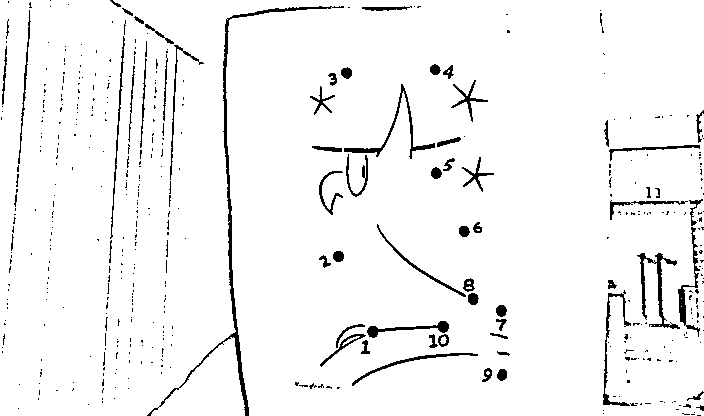

In [269]:
display(img)

In [270]:
detections = yolo.predict(img)

(1, 608, 608, 1)
completed in 9.352509 seconds


In [271]:
clean_detections = post_process(yolo_output=detections, obj_thresh=.02, nms_thresh=.2)

In [272]:
def get_nums_and_dots(detection):
    
    dots = []
    nums = {}

    for detection in clean_detections:

        bbox = detections[0]
        obj_type = detection[1]
        class_score = detection[2]

        if obj_type == 0:
            dots.append(detection)
        elif obj_type not in nums:
            nums[obj_type] = detection
        elif class_score > nums[obj_type][2]:
            nums[obj_type] = detection
            
    
    # now have best num and dots
            
    return nums, dots

In [273]:
def draw_objs(img, nums, dots):
    
    val2col = {0:(255,0,0), 1:(0,128,0), 2:(255,255,0), 3:(128, 255,0), 4:(0,255,255), 5:(255,255,0), 6:(0,128,255), 7:(127,255,0), 8:(255,0,255),9:(0,0,0), 10:(32,32,32)}

    pic = Image.fromarray(cv2.resize(img, (608, 608)))
    draw = ImageDraw.Draw(pic)

    for dot in dots:
        draw.rectangle(xy=dot[0], outline=val2col[dot[1]])

    for num, det in nums.items():
        draw.rectangle(xy=det[0], outline=val2col[num])

    return pic

In [274]:
def get_center(bbox):
    return (bbox[0] + bbox[2])/2.0, (bbox[1] + bbox[3])/2.0

def distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    
def draw_lines(img, nums, dots):
    pic = Image.fromarray(cv2.resize(img, (608, 608)))
    draw = ImageDraw.Draw(pic)
    
    dot_centers = []

    removed_dots = set()
    
    for cur_num in sorted(nums):
        num_center = get_center(nums[cur_num][0])
        best_dist = 10000000000
        best_index = -1
        best_center = None
        
        for i, dot_vals in enumerate(dots):
            if i in removed_dots:
                continue
                
            dot_center = get_center(dot_vals[0])
            
            dist = distance(num_center, dot_center) 

            if dist < best_dist:
                best_dist = dist
                best_index = i
                best_center = dot_center
        

        if best_index > -1:
            removed_dots.add(best_index)
            dot_centers.append(best_center)
        
    for i in range(len(dot_centers)-1):
        draw.line(xy=[dot_centers[i], dot_centers[i+1]], fill=(0,0,0), width=3)

    return pic

In [275]:
nums, dots = get_nums_and_dots(detection)

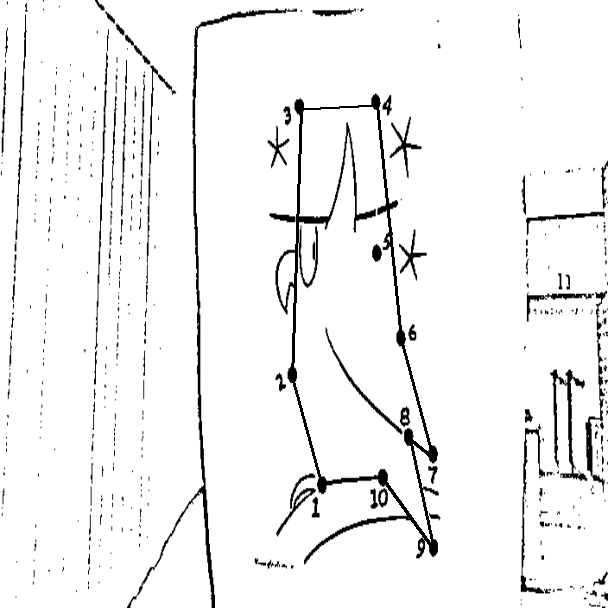

In [276]:
draw_lines(img, nums, dots)